<a href="https://colab.research.google.com/github/jshinm/code_bucket/blob/main/LSTM_multi_label_classification_BCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label Classification of BCI dataset by LSTM
The goal was to train a basic LSTM model to classify BCI dataset that has 4 labels (left hand, right hand, feet, tongue). The result of trained LSTM model was compared before and after extensive data engineering, which improved test accuracy by almost 20%.

## Model Import

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as spio
import scipy.stats as stat
from scipy import signal
import pandas as pd
import numpy as np
import os
import keras
import warnings

from keras.layers import Bidirectional, LSTM
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Input, Dense, Flatten, Dropout, Conv1D, MaxPool1D, AveragePooling1D  # https://keras.io/api/layers/convolution_layers/convolution1d/
from keras.layers import LeakyReLU

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

## Code for downloading shared folder from google drive

In [ ]:
def folder_download(folder_id):
  # authenticate
  from google.colab import auth
  auth.authenticate_user()
  # get folder_name
  from googleapiclient.discovery import build
  service = build('drive', 'v3')
  folder_name = service.files().get(fileId=folder_id).execute()['name']
  # import library and download
  !wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py
  from download import download_folder
  download_folder(service, folder_id, './', folder_name)
  return folder_name

In [ ]:
# folder_download('15ninVW5dNJ93rankbYLo6xQOMgDyElBU')

## Dataloader/feature extraction adapted from Tina Cao

In [ ]:
#-------------------------------------------------------------------------------
#----------------- Download Dataset --------------------------------------------
#-------------------------------------------------------------------------------
'''

DATA FORMAT:
- Official link: https://lampx.tugraz.at/~bci/database/001-2014/description.pdf
- Request data here: https://drive.google.com/drive/folders/15ninVW5dNJ93rankbYLo6xQOMgDyElBU?usp=sharing 
- Each data in the shared drive folder is named A0(X)(X).mat
    - The first (X) is a number 1-9 representing the participant number
    - The second (X) is either "T" or "E" for training or evaluation data
- Each data is a list that contains a total of 9 runs: The first 3 runs are EOG
  signals, and the last 6 runs are EEG signals. Once downloaded into this google
  colab doc, each run is represented in a dictionary with the following 
  keys: 
    - "X": is an Nx25 array, where N is the number of samples in the run and 25
    is the number of channels
    - "trial": is an array of length 48, whose values represent the sample  
    number in "X" at which a new "trial" starts i.e. at which a new 
    classification "label" is given
    - "y": is an array of length 48, whose values represent the "labels" for 
    training; in each run there are the same numbers of each label (i.e. 12 out
    of the 48 labels are the same because there are 4 classes; 12*4=49)
    - "classes": is an array of length 4, where there are 4 classes that each 
    label can represent
    - "artifacts": is an array of length 48, whoses values denote whether that 
    trial needs to be processed for artifacts (1) or not (0); if that trial
    needs processing, it will need to be processed using EOG data
    - "gender": is a string that says whether the participant is male or female
    - "age": is an integer that gives the age of the participant
  (*) NOTE 1: The first three "runs" or first three indices in each data is EOG
      data, so it will have empty values for "trial", "y", "classes", and 
      "artifacts"; these first three runs are purely used for processing the 
      EEG signals that need it due to the existence of artifacts
  (*) NOTE 2: Due to technical problems the EOG block is shorter for subject 
      A04T and only contains 1 EOG run, so it has 1 EOG + 6 EEG = 7 runs as 
      opposed to the usual 9 runs

GENERAL NOTES: Will take around 25 seconds to run this code, please be patient 
'''

# Access drive
from google.colab import drive
drive.mount("/content/drive/")

# Parameters from experiment
numSubjects = 9
numTrials = 48
numChannels = 25

# Get data names and path variables
filePath = "/content/drive/MyDrive/JHU_NDD/MLMA - FP dataset/"
dataNames = [""] * 2 * numSubjects
for i in range(numSubjects):
  dataNames[2 * i] = "A0" + str(i + 1) + "T"
  dataNames[2 * i + 1] = "A0" + str(i + 1) + "E"

# Get training and testing data from drive
for name in dataNames:
  # Upload raw data
  dataRaw = spio.loadmat(filePath + name + ".mat", squeeze_me=True)
  # Put processed data in a dictionary
  numRuns = len(dataRaw['data'])
  vars()[name] = [{}] * numRuns
  for i in range(numRuns):
    vars()[name][i] = {
        "X": np.array(np.asarray(list(list(dataRaw['data'][i]['X'].reshape((1)))[0]))),
        "trial": np.array(np.ndarray.tolist(dataRaw['data'][i]['trial'])),
        "y": np.array(np.ndarray.tolist(dataRaw['data'][i]['y'])),
        "fs": list(dataRaw['data'][i]['fs'].reshape((1)))[0],
        "classes": np.array(np.ndarray.tolist(dataRaw['data'][i]['classes'])),
        "artifacts": np.array(np.ndarray.tolist(dataRaw['data'][i]['artifacts'])),
        "gender": list(dataRaw['data'][i]['gender'].reshape((1)))[0],
        "age": list(dataRaw['data'][i]['age'].reshape((1)))[0],
        }

Mounted at /content/drive/


## Dataset exploration

In [ ]:
vars()['A07T'][3]

{'X': array([[  5.37109375,   9.9609375 ,   8.10546875, ...,   1.953125  ,
           2.44140625, -20.01953125],
        [  0.68359375,   2.34375   ,   3.90625   , ...,  -9.27734375,
          -3.41796875,   8.30078125],
        [  3.36914062,   8.10546875,   6.8359375 , ...,  -4.39453125,
           1.46484375,   0.9765625 ],
        ...,
        [ 22.70507812,  18.84765625,  19.921875  , ...,   8.7890625 ,
          30.2734375 ,  13.18359375],
        [ 17.72460938,  16.45507812,  17.91992188, ...,   6.34765625,
          23.4375    ,   6.34765625],
        [ 21.19140625,  20.55664062,  21.77734375, ...,   8.30078125,
          28.3203125 ,   7.32421875]]),
 'age': 25,
 'artifacts': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0], dtype=uint8),
 'classes': array(['left hand', 'right hand', 'feet', 'tongue'], dtype=object),
 'fs': 250,
 'gender': 'male',
 'trial': arr

In [ ]:
len(X_train)

2010

In [ ]:
numTrials, numChannels, numRunsEEG

(48, 25, range(3, 9))

In [ ]:
f.shape, t.shape, Sxx.shape

((129,), (2,), (129, 2))

In [ ]:
vars()['A01E'][0]['X'].shape

(34291, 25)

In [ ]:
for i in range(1,9):
    if i != 4:
        participant = f"A0{i}" 
        data_train = vars()[participant + "T"]
        f, t, Sxx = signal.spectrogram(data_train[8]['X'][range1:range1+fs*3,channel], fs)#, nperseg=256)
        print(f'{f.shape}, {t.shape}, {Sxx.shape}, {t}')

(129,), (3,), (129, 3), [0.512 1.408 2.304]
(129,), (3,), (129, 3), [0.512 1.408 2.304]
(129,), (3,), (129, 3), [0.512 1.408 2.304]
(129,), (3,), (129, 3), [0.512 1.408 2.304]
(129,), (3,), (129, 3), [0.512 1.408 2.304]
(129,), (3,), (129, 3), [0.512 1.408 2.304]
(129,), (3,), (129, 3), [0.512 1.408 2.304]


In [ ]:
t

array([0.512, 1.408])

In [ ]:
for i in Sxx.T:
    print(i.mean())

2.30470513973873
0.9835114959970024
0.8205234429522122


In [ ]:
#N x M x O x P where N is a vectorized trial and run (trial*run), M is a number of channels, O is a low filtered freq (<31), and P is the reference time in sec
len(X_train), X_train[0].shape, len(X_test), X_test[0].shape

(2010, (1, 129, 2), 2010, (1, 129, 2))

In [ ]:
len(y_train), y_train[0], len(y_test), y_test[0]

(2010, array(2), 2010, array(1))

## Initial run without any data engineering

In [ ]:
# #-------------------------------------------------------------------------------
# #----------------- Feature Extraction - Spectrogram ----------------------------
# #-------------------------------------------------------------------------------
'''
All participants (except A04)
'''

# Initialize participant-specific information
X_train = [[]] 
y_train = [[]]
X_test = [[]] 
y_test = [[]]

numChannels = 25

for n in range (1,9):
  if n == 4: # Don't specify A04 because it has technical issues!!
    continue
  else:
    participant = f"A0{n}" 
    numRunsEEG = range(3,9)
    data_train = vars()[participant + "T"]
    data_test = vars()[participant + "E"]
    # Extract training features and label
    for run in numRunsEEG:
      for trial in range(numTrials):
        feature = []
        for channel in range(numChannels):
          fs = data_train[run]['fs']
          if trial == (numTrials - 1):
            range1 = data_train[run]['trial'][trial]
            range2 = len(data_train[run]['X'][:,channel])
          else:
            range1 = data_train[run]['trial'][trial]
            range2 = data_train[run]['trial'][trial+1]
          # Create spectrogram
          f, t, Sxx = signal.spectrogram(data_train[run]['X'][range1:range2,channel], fs) #acquire only the cue [range1+fs*2:range1+fs*4]
          # Bandpass spectrogram to below 30 Hz (https://www.hindawi.com/journals/cmmm/2020/1981728/)
          feature.append(Sxx[0:31,:])
        X_train.append(np.array(feature))
        y_train.append(np.array(data_train[run]['y'][trial]-1))
    # Final processing
    X_train = X_train[1:]
    y_train = y_train[1:]

    # Extract testing features and label
    count = 0
    for run in numRunsEEG:
      for trial in range(numTrials):
        feature = []
        for channel in range(numChannels):
          fs = data_test[run]['fs']
          if trial == (numTrials - 1):
            range1 = data_test[run]['trial'][trial]
            range2 = len(data_test[run]['X'][:,channel])
          else:
            range1 = data_test[run]['trial'][trial]
            range2 = data_test[run]['trial'][trial+1]
          # Create spectrogram
          f, t, Sxx = signal.spectrogram(data_test[run]['X'][range1:range2,channel], fs) #acquire only the cue
          # Bandpass spectrogram to below 30 Hz (https://www.hindawi.com/journals/cmmm/2020/1981728/)
          feature.append(Sxx[0:31,:])
        X_test.append(np.array(feature))
        y_test.append(np.array(data_test[run]['y'][trial]-1))
    # Final processing
    X_test = X_test[1:]
    y_test = y_test[1:]        

In [ ]:
ts, fq, ch = X_train[0].transpose(2,1,0).shape #time steps
ts -= 1 #dropping excess time steps to equalize the shape
ts, fq, ch, ts* fq* ch

(8, 31, 25, 6200)

In [ ]:
# Prep data
X_train_in = []
X_test_in = []

for i in range(len(X_train)):
    X_train_in.append(X_train[i][:,:,:ts].transpose(2,1,0).reshape((ts,fq*ch))) #reshape into 3D input (batch, time steps, features)

for i in range(len(X_test)):
    X_test_in.append(X_test[i][:,:,:ts].transpose(2,1,0).reshape((ts,fq*ch)))

X_train_in1 = np.array(X_train_in)
X_test_in1 = np.array(X_test_in)
y_train1 = tf.keras.utils.to_categorical(y_train)
y_test1 = tf.keras.utils.to_categorical(y_test)

In [ ]:
bs = 80

# Initialize
model = Sequential()

#retain memory between batches
# model.add(LSTM(16*4, dropout=0.5, recurrent_dropout=0.5, batch_input_shape=(bs, ts, fq*ch), stateful=True, return_sequences=True))
# model.add(LSTM(16*4, dropout=0.5, recurrent_dropout=0.5, batch_input_shape=(bs, ts, fq*ch), stateful=True))

#multiple LSTMs
# model.add(LSTM(16*4, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
# model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))

model.add(LSTM(bs, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(loss = 'categorical_crossentropy',
            optimizer = optimizers.Adam(learning_rate=0.001, epsilon=1e-8),
            metrics = ['accuracy'])

# Fit
history = model.fit(X_train_in1, y_train1,
                    epochs = 80,
                    validation_split = 0.3,
                    batch_size = bs, verbose=0)

# Testing accuracy 
test_acc, test_loss = model.evaluate(X_test_in1, y_test1, verbose=2, batch_size=bs)

26/26 - 0s - loss: 2.0672 - accuracy: 0.3055


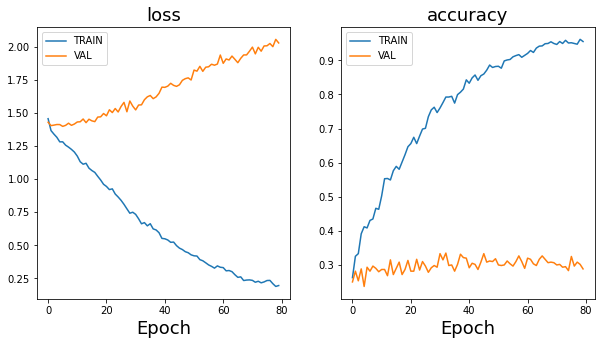

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(5*2,5))

for i, label in enumerate(['loss', 'accuracy']):
    axs[i].plot(history.history[label], label='TRAIN')
    axs[i].plot(history.history[f'val_{label}'], label='VAL')
    axs[i].set_xlabel('Epoch', fontsize=18)
    axs[i].set_title(label, fontsize=18)
    axs[i].legend()

## LSTM training after data engineering
- Filter for Cue and P300 (2-4s)
- Select specific channels
- Remove low-pass filter
- Normalize
- Pseudo-shuffle the order of subjects and order of channels

In [ ]:
def normalize(x):
    '''
    sample-wise normalization
    '''
    for i in range(len(x)):
        x[i] = (x[i] - x[i].mean()) / x[i].std()
    # x = (x - x.min()) / (x.max() - x.min())
    return x

In [ ]:
ts, fq, ch = X_train[0].transpose(2,1,0).shape #time steps
ts -= 1
ts, fq, ch, ts* fq* ch

(8, 31, 25, 6200)

In [ ]:
# Prep data
X_train_in = []
X_test_in = []

for i in range(len(X_train)):
    X_train_in.append(X_train[i][:,:,:ts].transpose(2,1,0).reshape((ts,fq*ch))) #reshape into 3D input (batch, time steps, features)

for i in range(len(X_test)):
    X_test_in.append(X_test[i][:,:,:ts].transpose(2,1,0).reshape((ts,fq*ch)))

X_train_in1 = np.array(X_train_in)
X_test_in1 = np.array(X_test_in)
y_train1 = tf.keras.utils.to_categorical(y_train)
y_test1 = tf.keras.utils.to_categorical(y_test)

In [ ]:
#-------------------------------------------------------------------------------
#----------------- Feature Extraction - Spectrogram ----------------------------
#-------------------------------------------------------------------------------
'''
All participants (except A04)
'''

def prepData(numChannels, numSamples, data):

    # Initialize participant-specific information
    X_train = [[]]
    y_train = [[]]
    X_test = [[]]
    y_test = [[]]

    for n in numSamples:
        if n == 4:  # Don't specify A04 because it has technical issues!!
            continue
        else:
            participant = f"A0{n}"
            numRunsEEG = range(3, 9)
            # numRunsEEG = range(3, 4)
            # data_train = vars()[participant + "T"]
            # data_test = vars()[participant + "E"]

            data_train = data[participant + "T"]
            data_test = data[participant + "E"]

            # Extract training features and label
            for run in numRunsEEG:
                for trial in range(numTrials):
                    feature = []
                    for channel in numChannels:
                        fs = data_train[run]['fs']
                        if trial == (numTrials - 1):
                            range1 = data_train[run]['trial'][trial]
                            range2 = len(data_train[run]['X'][:, channel])
                        else:
                            range1 = data_train[run]['trial'][trial]
                            range2 = data_train[run]['trial'][trial+1]
                        # Create spectrogram
                        # acquire only the cue [range1+fs*2:range1+fs*4]
                        f, t, Sxx = signal.spectrogram(
                            data_train[run]['X'][range1+fs*2:range1+fs*4, channel], fs)
                        # Bandpass spectrogram to below 30 Hz (https://www.hindawi.com/journals/cmmm/2020/1981728/)
                        feature.append(Sxx[0:30, :])
                    X_train.append(np.array(feature))
                    y_train.append(np.array(data_train[run]['y'][trial]-1))
            # Final processing
            X_train = X_train[1:]
            y_train = y_train[1:]

            # Extract testing features and label
            count = 0
            for run in numRunsEEG:
                for trial in range(numTrials):
                    feature = []
                    for channel in numChannels:
                        fs = data_test[run]['fs']
                        if trial == (numTrials - 1):
                            range1 = data_test[run]['trial'][trial]
                            range2 = len(data_test[run]['X'][:, channel])
                        else:
                            range1 = data_test[run]['trial'][trial]
                            range2 = data_test[run]['trial'][trial+1]
                        # Create spectrogram
                        f, t, Sxx = signal.spectrogram(
                            data_test[run]['X'][range1+fs*2:range1+fs*4, channel], fs)  # acquire only the cue
                        # Bandpass spectrogram to below 30 Hz (https://www.hindawi.com/journals/cmmm/2020/1981728/)
                        feature.append(Sxx[0:30, :])
                    X_test.append(np.array(feature))
                    y_test.append(np.array(data_test[run]['y'][trial]-1))
            # Final processing
            X_test = X_test[1:]
            y_test = y_test[1:]  

    ts, fq, ch = X_train[0].transpose(2,1,0).shape #time steps
    ts -= 1
    # ts, fq, ch, ts* fq* ch

    # Prep data
    X_train_in = []
    X_test_in = []

    for i in range(len(X_train)):
        X_train_in.append(X_train[i][:,:,:ts].transpose(2,1,0).reshape((ts,fq*ch))) #reshape into 3D input (batch, time steps, features)

    for i in range(len(X_test)):
        X_test_in.append(X_test[i][:,:,:ts].transpose(2,1,0).reshape((ts,fq*ch)))

    X_train_in1 = normalize(np.array(X_train_in))
    X_test_in1 = normalize(np.array(X_test_in))
    y_train1 = tf.keras.utils.to_categorical(y_train)
    y_test1 = tf.keras.utils.to_categorical(y_test)    

    return X_train_in1, X_test_in1, y_train1, y_test1 

In [ ]:
def train_model(X_train_in1, y_train1, X_test_in1, y_test1):
    bs = 80

    # Initialize
    model = Sequential()

    #retain memory between batches
    # model.add(LSTM(16*4, dropout=0.5, recurrent_dropout=0.5, batch_input_shape=(bs, ts, fq*ch), stateful=True, return_sequences=True))
    # model.add(LSTM(16*4, dropout=0.5, recurrent_dropout=0.5, batch_input_shape=(bs, ts, fq*ch), stateful=True))

    #multiple LSTMs
    # model.add(LSTM(16*4, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
    # model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))

    model.add(LSTM(bs, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(4, activation='softmax'))

    # Compile
    model.compile(loss = 'categorical_crossentropy',
                optimizer = optimizers.Adam(learning_rate=0.001, epsilon=1e-8),
                metrics = ['accuracy'])

    # Fit
    history = model.fit(X_train_in1, y_train1,
                        epochs = 80,
                        validation_split = 0.3,
                        batch_size = bs, verbose=0)
    
    # Testing accuracy 
    test_acc, test_loss = model.evaluate(X_test_in1, y_test1, verbose=2, batch_size=bs)

    fig, axs = plt.subplots(1,2,figsize=(5*2,5))

    acc = [[] for i in range(3)]
    loss = [[] for i in range(3)]

    for i, label in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[label], label='TRAIN')
        axs[i].plot(history.history[f'val_{label}'], label='VAL')
        axs[i].set_xlabel('Epoch', fontsize=18)
        axs[i].set_title(label, fontsize=18)
        axs[i].legend()

        if i == 0:
            loss[0].append(history.history[label])
            loss[1].append(history.history[f'val_{label}'])
            loss[2].append(test_loss)
        else:
            acc[0].append(history.history[label])
            acc[1].append(history.history[f'val_{label}'])
            acc[2].append(test_acc)

    # plt.show()

    return history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], test_loss, test_acc, acc, loss

Channels: [21 22 23 25 24] 
Samples: [4 5 8 3 2 6 1 7]
26/26 - 0s - loss: 1.4283 - accuracy: 0.4831
Train Acc: 0.8941009044647217, Val Acc: 0.4842454493045807, Train Loss: 0.3414094150066376, Val Loss: 1.3564637899398804, Test Acc: 0.4830845892429352, Test Loss: 1.4283413887023926
Channels: [25 24 23 22 21] 
Samples: [5 1 6 4 8 2 7 3]
26/26 - 0s - loss: 1.4714 - accuracy: 0.4597
Train Acc: 0.8926794528961182, Val Acc: 0.45605307817459106, Train Loss: 0.3801787197589874, Val Loss: 1.4619603157043457, Test Acc: 0.4597014784812927, Test Loss: 1.4714361429214478
Channels: [25 21 24 23 22] 
Samples: [4 6 8 7 1 2 5 3]
26/26 - 0s - loss: 1.4617 - accuracy: 0.4517
Train Acc: 0.8884150385856628, Val Acc: 0.43283581733703613, Train Loss: 0.37433916330337524, Val Loss: 1.5281245708465576, Test Acc: 0.4517413079738617, Test Loss: 1.461745023727417
Channels: [23 22 25 24 21] 
Samples: [5 8 4 1 3 6 7 2]
26/26 - 0s - loss: 1.4776 - accuracy: 0.4468
Train Acc: 0.8941009044647217, Val Acc: 0.5041459202

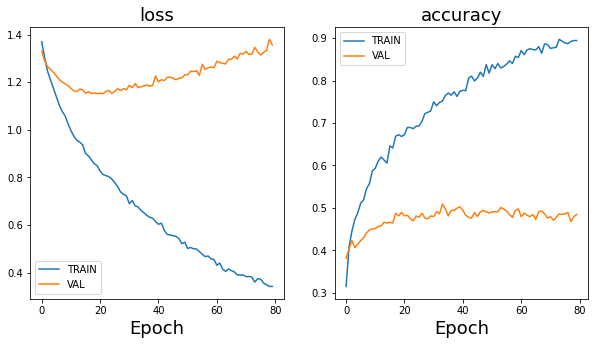

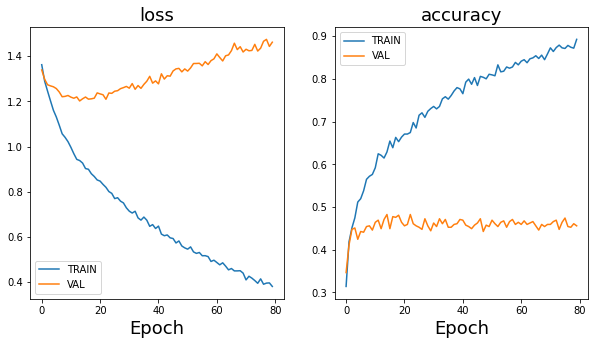

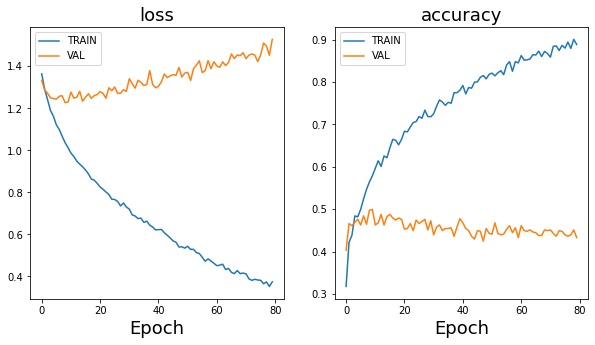

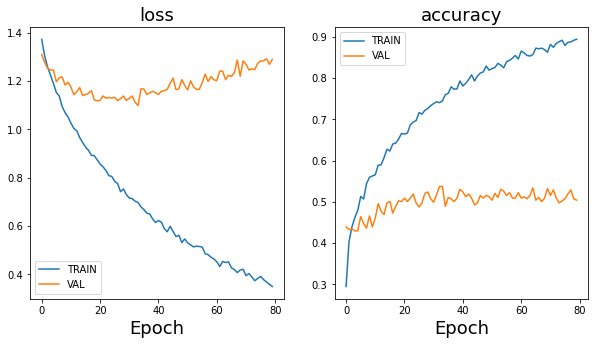

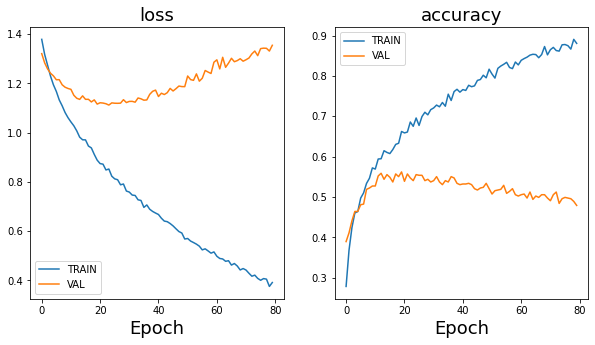

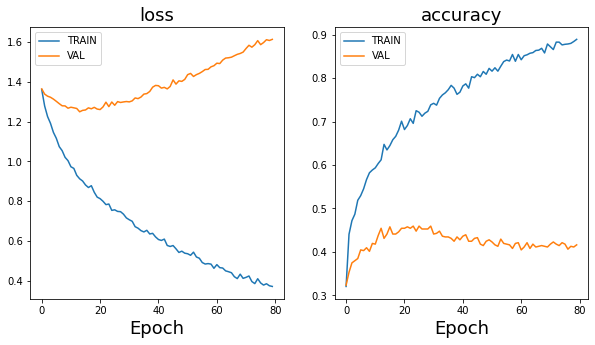

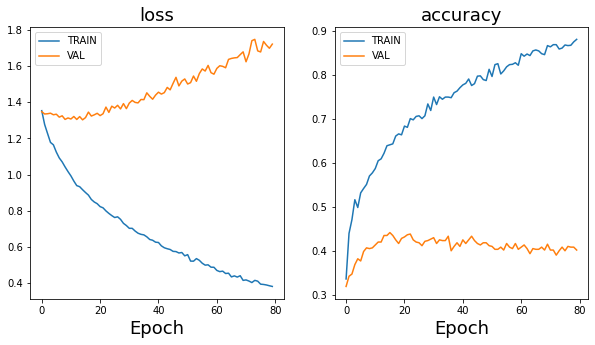

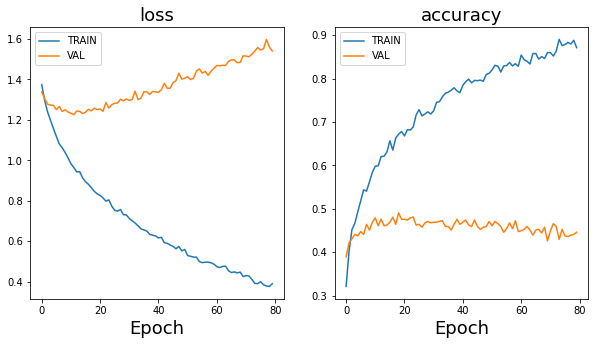

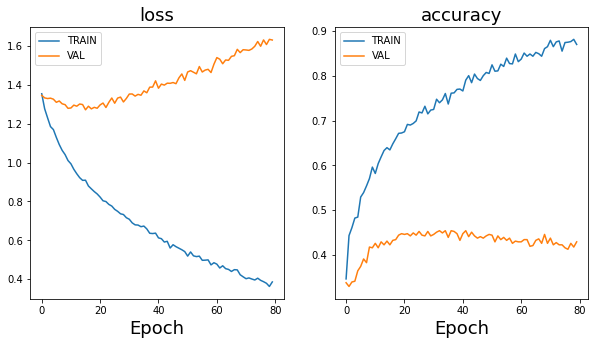

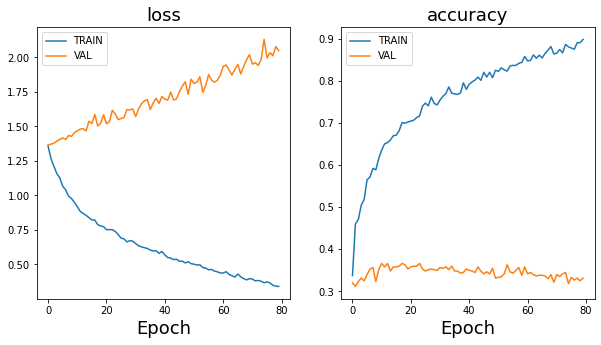

In [ ]:
rep = 10

numSamples = [np.random.choice(range(1,9), 8, replace=False) for i in range(rep)]
numChannels = [np.random.choice(range(20,25), 5, replace=False) for i in range(rep)]

acc, loss = [], []

for i,j in zip(numChannels, numSamples):
    print(f'Channels: {i+1} \nSamples: {j}')
    X1, X2, Y1, Y2 = prepData(i, j, vars())
    a,b,c,d,e,f,g,h = train_model(X1,Y1,X2,Y2)
    print(f'Train Acc: {a}, Val Acc: {b}, Train Loss: {c}, Val Loss: {d}, Test Acc: {e}, Test Loss: {f}')
    acc.append(g)
    loss.append(h)

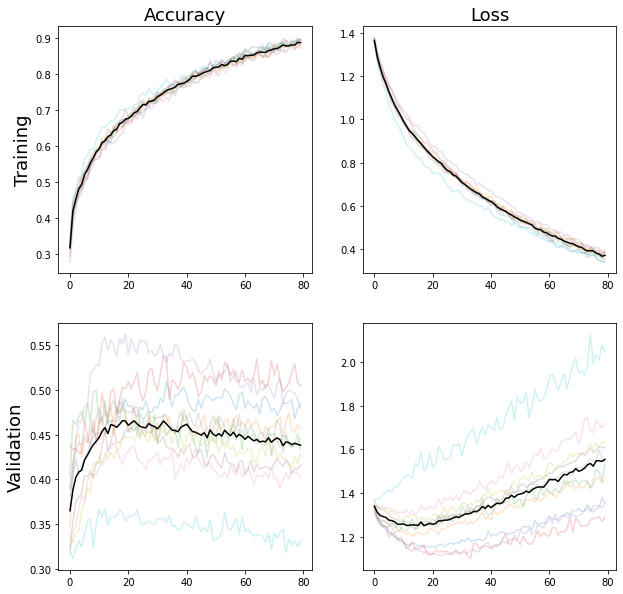

In [ ]:
# np.array(acc)[0]
fig, axs = plt.subplots(2,2, figsize=(5*2,5*2))

for i in range(2):
    for j in range(2):
        items = [acc, loss][j]
        temp = []
        for item in items:
            temp.append(item[i][0])
            axs[i,j].plot(item[i][0],alpha=0.2)

        axs[i,j].plot(np.array(temp).mean(axis=0),'k-')

        if j == 0:
            axs[i,j].set_ylabel(['Training', 'Validation'][i], fontsize=18)
        
        if i == 0:
            axs[i,j].set_title(['Accuracy', 'Loss'][i], fontsize=18)

In [ ]:
# np.array(acc[0][2])#.shape
temp_acc = []
temp_loss = []

for i in loss:
    temp_acc += i[2]

for i in acc:
    temp_loss += i[2]

pd.DataFrame([temp_acc,temp_loss], index=['Accuracy', 'Loss']).T.describe()

,Accuracy,Loss
count,10.000000,10.000000
mean,0.476269,1.449681
std,0.019200,0.023609
min,0.446766,1.413638
25%,0.461816,1.431909
50%,0.479353,1.445397
75%,0.490050,1.469013
max,0.502985,1.484552


End of Notebook